In [2]:
%matplotlib inline
import torch
import numpy as np
import sys
sys.path.append('/home/cxking/桌面/code/d2lzh_pytorch')
import utils as d2l

# 生成数据集
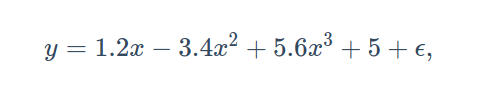

其中噪声项ϵϵ服从均值为0、标准差为0.01的正态分布。训练数据集和测试数据集的样本数都设为100。

In [7]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train + n_test, 1))
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1) 
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
          + true_w[2] * poly_features[:, 2] + true_b)
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

features[:2], poly_features[:2], labels[:2]


(tensor([[-0.2653],
         [ 1.7748]]),
 tensor([[-0.2653,  0.0704, -0.0187],
         [ 1.7748,  3.1500,  5.5908]]),
 tensor([ 4.3466, 27.7307]))

# 作图函数semilogy 

In [9]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)


# 构建不同复杂程度的模型，将模型放入fit_and_plot函数中

In [12]:
num_epochs, loss = 100, torch.nn.MSELoss()  #迭代次数、损失函数

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = torch.nn.Linear(train_features.shape[-1], 1)  
    #稍微一看，shape为(x,)和shape为(x,1)几乎一样，都是一维的形式。其实不然：
        #(x,)意思是一维数组，数组中有2个元素
        #(x,1)意思是一个x维数组，每行有1个元素
    #shape[-1] 为第二维元素个数
    # 通过Linear文档可知，pytorch已经将参数初始化了，所以我们这里就不手动初始化了

    batch_size = min(10, train_labels.shape[0])    
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1, 1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_ls.append(loss(net(train_features), train_labels).item())
        test_ls.append(loss(net(test_features), test_labels).item())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net.weight.data,
          '\nbias:', net.bias.data)


# 三阶多项式函数正常拟合
我们先使用与数据生成函数同阶的三阶多项式函数拟合。实验表明，这个模型的训练误差和在测试数据集的误差都较低。训练出的模型参数也接近真实值：w1=1.2,w2=−3.4,w3=5.6,b=5

final epoch: train loss 0.00011516026279423386 test loss 9.560828766552731e-05
weight: tensor([[ 1.2003, -3.3997,  5.5999]]) 
bias: tensor([4.9999])


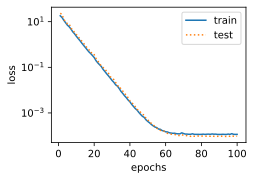

In [14]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], 
            labels[:n_train], labels[n_train:])


# 线性函数拟合（一阶多项式）（欠拟合） 

final epoch: train loss 222.49546813964844 test loss 206.04103088378906
weight: tensor([[20.6688]]) 
bias: tensor([-1.7606])


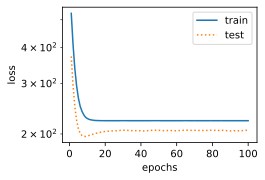

In [16]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train],
             labels[n_train:])


# 过拟合（训练样本不足） 

final epoch: train loss 1.0057214498519897 test loss 145.895751953125
weight: tensor([[0.3479, 2.2185, 3.0807]]) 
bias: tensor([2.9222])


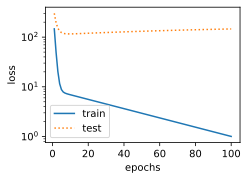

In [17]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2],
             labels[n_train:])
